In [1]:
import argparse
import torch
import pandas as pd
import numpy as np
import pylab
import copy
import matplotlib.pyplot as plt
import os
import sys

/home/dell/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
T = 1000
t = np.arange(T)/np.math.pi
t = t.reshape((T, 1))
W = np.sin(t*10)
# X = np.sin(3*t) + np.sin(7*t) + W
# data = np.concatenate((X, np.sin(3*t), np.sin(7*t)), axis=1)
Y = np.sin(t/10)
Y = (Y-Y.min())/(Y.max()-Y.min())
X = 3*Y + W
X = (X-X.min())/(X.max()-X.min())
# data = np.concatenate((X, W), axis=1)
data = np.concatenate((X, Y), axis=1)

In [78]:
T = 1000
t = np.arange(T)/np.math.pi
t = t.reshape((T, 1))
W = np.sin(t*10)
# X = np.sin(3*t) + np.sin(7*t) + W
# data = np.concatenate((X, np.sin(3*t), np.sin(7*t)), axis=1)
Y = 5e-2 * t**3 - 15 * t**2 - 80 * t**1 + 2
Y = (Y-Y.min())/(Y.max()-Y.min())
X = Y + 0.2*W*(0.2+Y)
X = (X-X.min())/(X.max()-X.min())
data = np.concatenate((X, X, Y), axis=1)

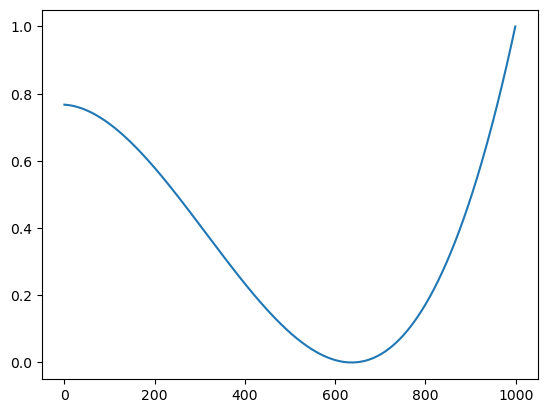

In [79]:
plt.plot(Y)

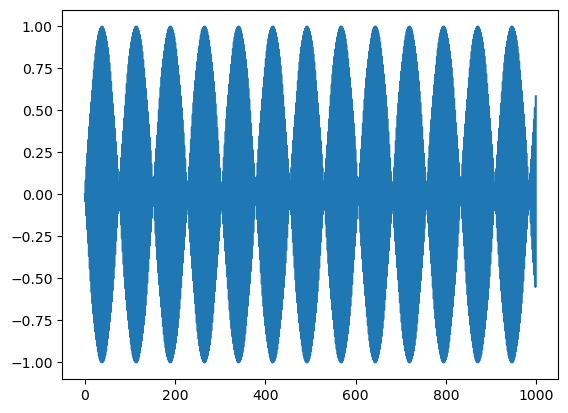

In [80]:
plt.plot(W)

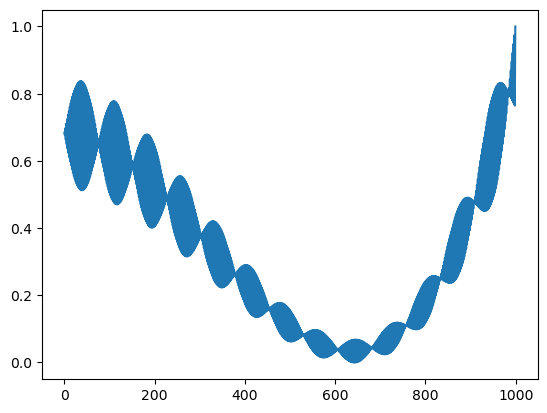

In [81]:
plt.plot(X)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
class Mine(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [4]:
class Z_RNN(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32, num_layers = 1, output_size = 2):
        super(Z_RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,     # rnn hidden unit
            num_layers = num_layers,       # number of rnn layer
            batch_first = True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        # print(r_out.shape)
        # outs = []    # save all predictions
        # for time_step in range(r_out.size(1)):    # calculate output for each time step
        #     outs.append(self.out(r_out[:, time_step, :]))

        # return torch.stack(outs, dim=1), h_state

        outs = self.out(r_out)
        return outs, h_state

In [5]:
def mutual_information(joint_X, marginal_X, Y, mine_net, zrnn_net, h_state):
    h_state = None
    Z, h_state = zrnn_net( torch.cat((joint_X, Y), axis = 1), h_state)
    # Z, h_state = zrnn_net(joint_X[:-1, :], h_state)
    t = mine_net( torch.cat((joint_X, Y, Z), axis = 1) )
    marginal_t = mine_net( torch.cat((marginal_X, Y, Z), axis = 1) )
    et = torch.exp(marginal_t)
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et, h_state

# def learn_mine(X, Y, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, ma_et, batch_size = 100, window_size = 100, ma_rate=0.01):
#     # batch is a tuple of (joint, marginal)
#     X_all = X
#     Y_all = Y
#     loss = 0
#     for _ in range(batch_size):
#         pivot = np.random.randint(X_all.shape[0]-window_size)
#         X = X_all[pivot:pivot+window_size]
#         Y = Y_all[pivot:pivot+window_size]
#         # index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
#         index = np.random.choice(range(X.shape[0]), size=window_size, replace=False)
#         marginal_X = X[index]
#         # marginal_X = marginal_X[pivot:pivot+window_size]

#         X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
#         Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
#         marginal_X = torch.autograd.Variable(torch.FloatTensor(marginal_X)).cuda()

#         mi_lb, t, et, h_state = mutual_information(X, marginal_X, Y, mine_net, zrnn_net, h_state)
#         ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
#     # unbiasing use moving average
#         loss += (-(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et)) )
#     # use biased estimator
# #     loss = - mi_lb
    
#     mine_net_optim.zero_grad()
#     zrnn_net_optim.zero_grad()
#     autograd.backward(loss)
#     nn.utils.clip_grad_norm(mine_net.parameters(), max_norm=0.1, norm_type=2)
#     nn.utils.clip_grad_norm(zrnn_net.parameters(), max_norm=0.1, norm_type=2)
#     mine_net_optim.step()
#     zrnn_net_optim.step()
#     return mi_lb, ma_et, loss, h_state

In [6]:
def learn_mine(X, Y, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, ma_et, batch_size = 100, window_size = 100, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    X_all = X
    Y_all = Y
    loss = 0
    # for _ in range(batch_size):
    pivot = np.random.randint(X_all.shape[0]-window_size)
    # pivot = 0
    X = X_all[pivot:pivot+window_size]
    Y = Y_all[pivot:pivot+window_size]
    # index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    index = np.random.choice(range(X.shape[0]), size=window_size, replace=False)
    marginal_X = X[index]
    # marginal_X = marginal_X[pivot:pivot+window_size]

    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    marginal_X = torch.autograd.Variable(torch.FloatTensor(marginal_X)).cuda()

    mi_lb, t, et, h_state = mutual_information(X, marginal_X, Y, mine_net, zrnn_net, h_state)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)

# unbiasing use moving average
    loss = (-(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et)) )
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    zrnn_net_optim.zero_grad()
    autograd.backward(loss)
    # nn.utils.clip_grad_norm(mine_net.parameters(), max_norm=0.1, norm_type=2)
    # nn.utils.clip_grad_norm(zrnn_net.parameters(), max_norm=0.1, norm_type=2)
    mine_net_optim.step()
    zrnn_net_optim.step()
    return mi_lb, ma_et, loss, h_state

In [7]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [8]:
def train(data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, result, loss, ma_et, batch_size=100, window_size=100, iter_num=int(10e+3) , log_freq=int(1e+3)):
# def train(data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, batch_size=100, iter_num=3000, log_freq=int(1e+2)):
    # data is x or y

    for i in tqdm(range(iter_num)):
        max_mi = 0
        # batch = sample_batch(data, batch_size = batch_size, sample_mode='joint'), \
        #         sample_batch(data, batch_size=batch_size, sample_mode='marginal')

        # index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        X = np.expand_dims(data[:, 0], 1)
        Y = data[:, 1:]
        if Y.ndim == 1:
            Y = np.expand_dims(Y, 1)
        mi_lb, ma_et, loss_, h_state = learn_mine(X, Y, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, ma_et, batch_size, window_size)
        h_state = h_state.data

        if mi_lb > max_mi:
            max_mi = mi_lb.detach().cpu().int()
            torch.save(zrnn_net.state_dict(), 'zrnn_net.pt')
            
        # if (i+1)%(10)==0:
        result.append(mi_lb.detach().cpu().numpy())
        loss.append(loss_.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(i, '/', iter_num, 'MI =', result[-1])
            # plt.plot(ma(result))

    return result, loss, ma_et

In [9]:
class Regressor(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [10]:
data = np.array(data)

train_proportion = 0.7
train_size = int(data.shape[0] * train_proportion)

train_data = data[:train_size]
test_data = data[train_size:]

batch_size = 20
window_size = 100 #train_data.shape[0]-1

z_size = 10

NameError: name 'data' is not defined

In [92]:
mine_net = Mine(input_size = data.shape[1]+z_size, hidden_size = 32).cuda()
mine_net_optim = optim.Adam(mine_net.parameters(), lr = 1e-3, weight_decay = 1e-5)
zrnn_net = Z_RNN(input_size = data.shape[1], hidden_size = data.shape[1]*2, num_layers = 2, output_size = z_size).cuda()
zrnn_net_optim = optim.Adam(zrnn_net.parameters(), lr = 1e-3, weight_decay = 1e-5)
h_state = torch.zeros((2, data.shape[1]*2))
h_state = h_state.to('cuda:0')

In [93]:
result = list()
loss = list()
ma_et = 1.

In [94]:
result, loss, ma_et = train(train_data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, result, loss, ma_et,
                            batch_size=batch_size, window_size=window_size, iter_num=int(40000), log_freq=int(4e+3))

 10%|█         | 4014/40000 [00:38<05:53, 101.88it/s]

3999 / 40000 MI = 2.7077446


 20%|██        | 8016/40000 [01:16<04:44, 112.46it/s]

7999 / 40000 MI = 3.1965356


 30%|███       | 12011/40000 [01:55<04:20, 107.31it/s]

11999 / 40000 MI = 2.9126148


 40%|████      | 16020/40000 [02:34<03:59, 100.26it/s]

15999 / 40000 MI = 2.5553854


 50%|█████     | 20019/40000 [03:13<03:16, 101.84it/s]

19999 / 40000 MI = 4.9133034


 60%|██████    | 24019/40000 [03:51<02:41, 99.12it/s] 

23999 / 40000 MI = 2.6751003


 70%|███████   | 28012/40000 [04:29<01:48, 110.70it/s]

27999 / 40000 MI = 3.717548


 80%|████████  | 32016/40000 [05:08<01:17, 102.92it/s]

31999 / 40000 MI = 2.9324164


 90%|████████▉ | 35998/40000 [05:46<00:37, 107.01it/s]

35999 / 40000 MI = 4.090521


100%|██████████| 40000/40000 [06:24<00:00, 104.01it/s]

39999 / 40000 MI = 3.1912844


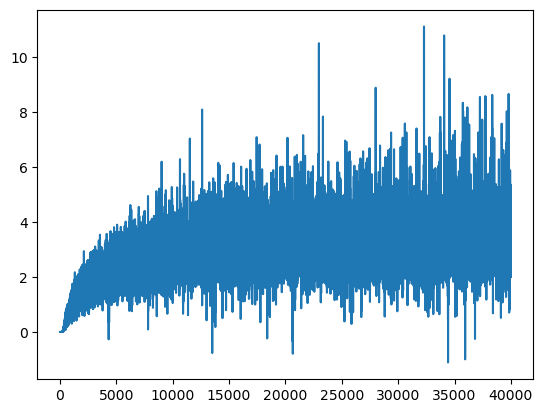

In [95]:
result_cor_ma = ma(result)
# print(result_cor_ma[-1])
# plt.plot(range(len(result)), result)
plt.plot(result)
# plt.plot(result_cor_ma)
# plt.plot(range(len(result_cor_ma)), result_cor_ma)
# plt.plot(range(200, 1300), result_cor_ma[200:1300])

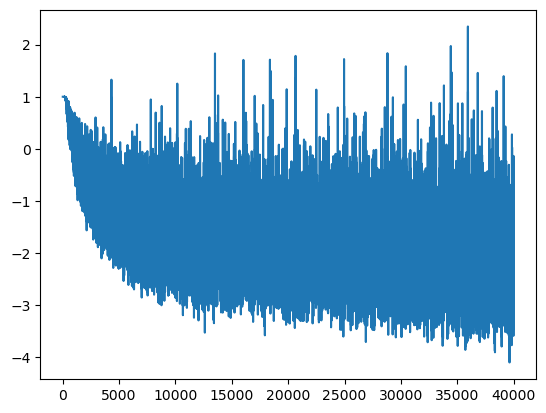

In [96]:
plt.plot(range(len(loss)), loss)

In [97]:
def generate_Z(data, zrnn_net):
    h_state = None
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]

    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    marginal_X = X[index]

    Z, h_state = zrnn_net( torch.cat((X, Y), axis = 1), h_state)
    Z = Z.detach().cpu().numpy()

    return Z

In [98]:
# z_spare = zrnn_net
zrnn_net.load_state_dict(torch.load('zrnn_net.pt'))

<All keys matched successfully>

In [99]:
Z = generate_Z(data, zrnn_net)
Z = (Z - Z.min())/(Z.max() - Z.min())# * 2 - np.ones((500, 1))

In [100]:
Z.shape

(1000, 10)

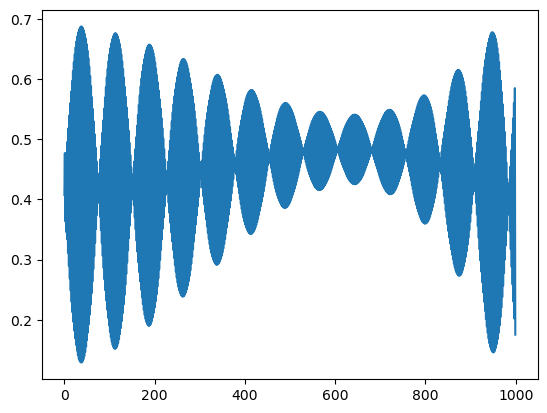

In [111]:
plt.plot(Z[:, 9])

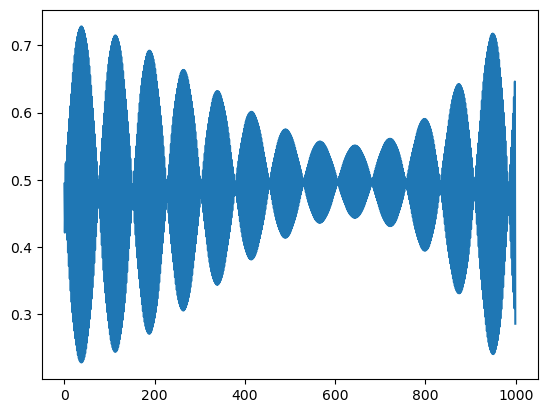

In [112]:
plt.plot(Z[:,1])
# for i in range(int(data.shape[1])):
#     z = data[:, i]
#     # z = (z - z.min())/(z.max() - z.min())
#     plt.plot(z[:100])
#     # dum += z

In [113]:
Z = Z[:, 1].reshape((1000, 1))

In [114]:
Z = (Z - Z.min())/(Z.max() - Z.min())

In [12]:
X = np.load('results/synthetic4_z.npy')[:, 0].reshape((1000, 1))
Y = np.load('results/synthetic4_z.npy')[:, 1].reshape((1000, 1))
W = np.load('results/synthetic4_z.npy')[:, 2].reshape((1000, 1))
Z = np.load('results/synthetic4_z.npy')[:, 3].reshape((1000, 1))

data = np.concatenate((X, Y), axis=1)

In [13]:
plt.figure()
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15, 9), dpi = 1000)
plt.subplots_adjust(hspace=0, wspace=0)

axs[0,0].plot(X)
axs[0,0].set(ylabel='Y', xlabel='t')

# axs[0,1].plot(Y, color='blue')
axs[0,1].plot(Y, linewidth = 0)
axs[0,1].plot(Y, linewidth = 0)
axs[0,1].plot(Y, linewidth = 0)
axs[0,1].plot(Y)
axs[0,1].set(ylabel='X', xlabel='t')
axs[0,1].yaxis.set_label_position('right')
axs[0,1].yaxis.tick_right()

# axs[1,0].plot(W, color='green')
axs[1,0].plot(W, linewidth = 0)
axs[1,0].plot(W, linewidth = 0)
axs[1,0].plot(W)
axs[1,0].set(ylabel='W', xlabel='t')

# axs[1,1].plot(Z, color='orange')
axs[1,1].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
axs[1,1].plot(Z)
axs[1,1].set(ylabel='Z', xlabel='t')
axs[1,1].yaxis.set_label_position('right')
axs[1,1].yaxis.tick_right()

plt.savefig('syn6y.pdf')

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure()
fig, axs = plt.subplots(4, 3, sharex=True, figsize=(15, 9), dpi = 1000)
plt.subplots_adjust(hspace=0, wspace=0)

col = 0
X = np.load('results/synthetic5_z.npy')[:, 0].reshape((1000, 1))
Y = np.load('results/synthetic5_z.npy')[:, 1].reshape((1000, 1))
W = np.load('results/synthetic5_z.npy')[:, 2].reshape((1000, 1))
Z = np.load('results/synthetic5_z.npy')[:, 3].reshape((1000, 1))
axs[0,col].plot(X)
axs[0,col].set(ylabel='Y', xlabel='t')
axs[0,col].set_ylim([-0.1, 1.1])

# axs[0,1].plot(Y, color='blue')
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y)
axs[1,col].set(ylabel='X', xlabel='t')
axs[1,col].set_ylim([-0.1, 1.1])
# axs[1,col].yaxis.set_label_position('right')
# axs[1,col].yaxis.tick_right()

# axs[1,0].plot(W, color='green')
axs[2,col].plot(W, linewidth = 0)
axs[2,col].plot(W, linewidth = 0)
axs[2,col].plot(W)
axs[2,col].set(ylabel='W', xlabel='t')
axs[2,col].set_ylim([-1.2, 1.2])

# axs[1,1].plot(Z, color='orange')
axs[3,col].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
axs[3,col].plot(Z)
axs[3,col].set(ylabel='Z', xlabel='t')
axs[3,col].set_ylim([-0.1, 1.1])
# axs[3,col].yaxis.set_label_position('right')
# axs[3,col].yaxis.tick_right()

X = np.load('results/synthetic2_z.npy')[:, 0].reshape((1000, 1))
Y = np.load('results/synthetic2_z.npy')[:, 1].reshape((1000, 1))
W = np.load('results/synthetic2_z.npy')[:, 2].reshape((1000, 1))
Z = np.load('results/synthetic2_z.npy')[:, 3].reshape((1000, 1))
col = 1
axs[0,col].plot(X)
axs[0,col].set_ylim([-0.1, 1.1])
axs[0,col].get_yaxis().set_visible(False)
# axs[0,col].set(ylabel='Y', xlabel='t')

# axs[0,1].plot(Y, color='blue')
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y)
axs[1,col].set_ylim([-0.1, 1.1])
axs[1,col].get_yaxis().set_visible(False)
# axs[1,col].set(ylabel='X', xlabel='t')
# axs[1,col].yaxis.set_label_position('right')
# axs[1,col].yaxis.tick_right()

# axs[1,0].plot(W, color='green')
axs[2,col].plot(W, linewidth = 0)
axs[2,col].plot(W, linewidth = 0)
axs[2,col].plot(W)
axs[2,col].set_ylim([-1.2, 1.2])
axs[2,col].get_yaxis().set_visible(False)
# axs[2,col].set(ylabel='W', xlabel='t')

# axs[1,1].plot(Z, color='orange')
axs[3,col].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
axs[3,col].plot(Z)
axs[3,col].set(xlabel='t')
axs[3,col].set_ylim([-0.1, 1.1])
axs[3,col].get_yaxis().set_visible(False)
# axs[3,col].yaxis.set_label_position('right')
# axs[3,col].yaxis.tick_right()

X = np.load('results/synthetic6_z.npy')[:, 0].reshape((1000, 1))
Y = np.load('results/synthetic6_z.npy')[:, 1].reshape((1000, 1))
W = np.load('results/synthetic6_z.npy')[:, 2].reshape((1000, 1))
Z = np.load('results/synthetic6_z.npy')[:, 3].reshape((1000, 1))
col = 2
axs[0,col].plot(X)
axs[0,col].set_ylim([-0.1, 1.1])
axs[0,col].get_yaxis().set_visible(False)
# axs[0,col].set(ylabel='Y', xlabel='t')

# axs[0,1].plot(Y, color='blue')
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y, linewidth = 0)
axs[1,col].plot(Y)
axs[1,col].set_ylim([-0.1, 1.1])
axs[1,col].get_yaxis().set_visible(False)
# axs[1,col].set(ylabel='X', xlabel='t')
# axs[1,col].yaxis.set_label_position('right')
# axs[1,col].yaxis.tick_right()

# axs[1,0].plot(W, color='green')
axs[2,col].plot(W, linewidth = 0)
axs[2,col].plot(W, linewidth = 0)
axs[2,col].plot(W)
axs[2,col].set_ylim([-1.2, 1.2])
axs[2,col].get_yaxis().set_visible(False)
# axs[2,col].set(ylabel='W', xlabel='t')

# axs[1,1].plot(Z, color='orange')
axs[3,col].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
# axs[1,1].plot(Z, linewidth = 0)
axs[3,col].plot(Z)
axs[3,col].set_ylim([-0.1, 1.1])
axs[3,col].get_yaxis().set_visible(False)
axs[3,col].set(xlabel='t')
# axs[3,col].yaxis.set_label_position('right')
# axs[3,col].yaxis.tick_right()

plt.savefig('syn6y.pdf')

<Figure size 640x480 with 0 Axes>

In [116]:
np.save('results/synthetic6_z.npy', np.concatenate((X, Y, W, Z), axis = 1))

In [15]:
def mutual_information_explicit(joint_X, marginal_X, Y, mine_net):
    t = mine_net( torch.cat((joint_X, Y), axis = 1) )
    marginal_t = mine_net( torch.cat((marginal_X, Y), axis = 1) )

    # Z, h_state = zrnn_net( torch.cat((joint_X[:-1, :], Y[:-1, :]), 1), h_state)
    # t = mine_net( torch.cat((joint_X[1:, :], Y[1:, :], Z), axis = 1) )
    # marginal_t = mine_net( torch.cat((marginal_X[1:, :], Y[1:, :], Z), axis = 1) )

    et = torch.exp(marginal_t)
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine_explicit(X, Y, mine_net, mine_net_optim, ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    marginal_X = X[index]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    marginal_X = torch.autograd.Variable(torch.FloatTensor(marginal_X)).cuda()

    mi_lb, t, et = mutual_information_explicit(X, marginal_X, Y, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et, loss

In [16]:
def train_explicit(data, mine_net, mine_net_optim, batch_size=100, iter_num=int(1e+3) , log_freq=int(1e+2)):
# def train(data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, batch_size=100, iter_num=3000, log_freq=int(1e+2)):
    # data is x or y
    result = list()
    loss = list()
    ma_et = 1.

    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    # Y = np.expand_dims(data[:, 0], 1)
    if Y.ndim == 1:
        Y = np.expand_dims(Y, 1)

    for i in tqdm(range(iter_num)):
        mi_lb, ma_et, l = learn_mine_explicit(X, Y, mine_net, mine_net_optim, ma_et)
        # if (i+1)%(10)==0:
        result.append(mi_lb.detach().cpu().numpy())
        loss.append(l.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result, loss

In [17]:
mine_net_explicit = Mine(input_size = data.shape[1], hidden_size = 32).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)
result_explicit = train_explicit(data, mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(4e+4), log_freq=int(4e+3))

 10%|█         | 4034/40000 [00:18<02:32, 236.28it/s]

1.1295519


 20%|██        | 8028/40000 [00:35<02:19, 229.75it/s]

1.1903694


 30%|███       | 12026/40000 [00:52<02:04, 224.45it/s]

1.0662738


 40%|████      | 16023/40000 [01:10<01:44, 230.44it/s]

1.2305912


 50%|█████     | 20035/40000 [01:27<01:27, 227.86it/s]

1.1827723


 60%|██████    | 24030/40000 [01:44<01:07, 236.11it/s]

1.1247206


 70%|███████   | 28032/40000 [02:02<00:53, 224.58it/s]

1.1170911


 80%|████████  | 32042/40000 [02:19<00:35, 224.04it/s]

1.0432847


 90%|█████████ | 36025/40000 [02:36<00:18, 213.92it/s]

1.2734711


100%|██████████| 40000/40000 [02:54<00:00, 229.75it/s]


1.2636611


In [18]:
np.max(result_explicit[0])

1.4404078

In [19]:
mine_net_explicit = Mine(input_size = data.shape[1]+1, hidden_size = 32).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)
result_explicit_plus_Z = train_explicit(np.concatenate((data, Z), axis = 1), mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(4e+4), log_freq=int(4e+3))

 10%|█         | 4028/40000 [00:18<02:53, 207.79it/s]

2.7876503


 20%|██        | 8037/40000 [00:35<02:31, 211.30it/s]

2.915768


 30%|███       | 12031/40000 [00:52<02:04, 223.90it/s]

3.0828183


 40%|████      | 16029/40000 [01:10<01:42, 233.07it/s]

3.1023197


 50%|█████     | 20028/40000 [01:28<01:29, 222.63it/s]

2.8274605


 60%|██████    | 24032/40000 [01:45<01:13, 216.84it/s]

3.253178


 70%|███████   | 28039/40000 [02:02<00:50, 235.02it/s]

3.3031368


 80%|████████  | 32039/40000 [02:20<00:34, 232.22it/s]

3.171729


 90%|█████████ | 36048/40000 [02:37<00:16, 240.71it/s]

3.4118314


100%|██████████| 40000/40000 [02:55<00:00, 228.30it/s]


3.3984196


In [20]:
np.max(result_explicit[0]), np.max(ma(result_explicit_plus_Z[0]))

(1.4404078, 3.4709408)

In [21]:
mine_net_explicit = Mine(input_size = 2, hidden_size = 32).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)
result_entropy = train_explicit(np.concatenate((X, X), axis = 1),
                                mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(4e+4), log_freq=int(4e+3))

 10%|█         | 4021/40000 [00:17<02:49, 212.16it/s]

4.3984885


 20%|██        | 8031/40000 [00:35<02:33, 208.05it/s]

4.2031326


 30%|███       | 12046/40000 [00:52<02:04, 224.90it/s]

4.924717


 40%|████      | 16050/40000 [01:09<01:38, 244.13it/s]

4.554819


 50%|█████     | 20027/40000 [01:27<01:30, 220.91it/s]

5.0942736


 60%|██████    | 24023/40000 [01:44<01:09, 229.49it/s]

4.941923


 70%|███████   | 28039/40000 [02:02<00:50, 237.28it/s]

4.979345


 80%|████████  | 32035/40000 [02:19<00:32, 241.54it/s]

4.6004443


 90%|█████████ | 36026/40000 [02:37<00:18, 215.91it/s]

4.5645533


100%|██████████| 40000/40000 [02:56<00:00, 227.23it/s]


5.519659


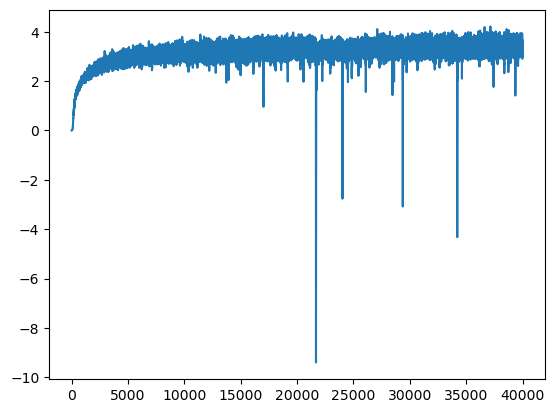

In [22]:
plt.plot(result_explicit_plus_Z[0])

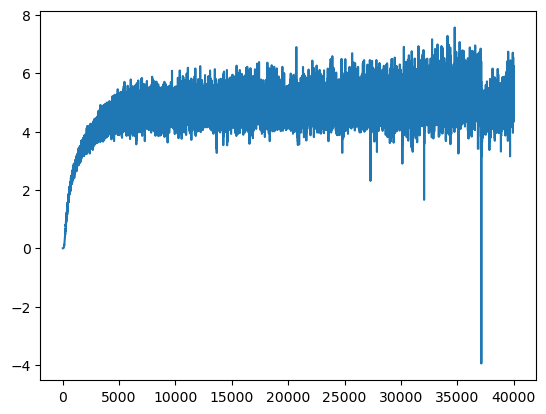

In [23]:
plt.plot(result_entropy[0])

In [24]:
np.max(result_explicit[0]), np.max(ma(result_explicit_plus_Z[0])), np.max(ma(result_entropy[0]))

(1.4404078, 3.4709408, 5.290486)

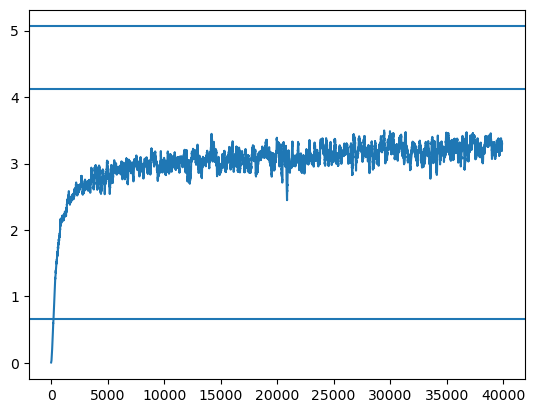

In [72]:
plt.axhline(np.max(result_explicit[0]))
plt.axhline(np.max(ma(result_explicit_plus_Z[0])))
plt.axhline(np.max(ma(result_entropy[0])))
plt.plot(ma(result))

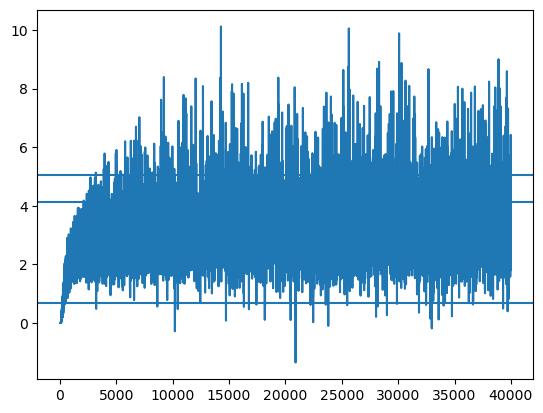

In [74]:
plt.plot(result)
plt.axhline(np.max(result_explicit[0]))
plt.axhline(np.max(ma(result_explicit_plus_Z[0])))
plt.axhline(np.max(ma(result_entropy[0])))

In [ ]:
data = np.array(data)

train_proportion = 0.7
train_size = int(data.shape[0] * train_proportion)

train_data = data[:train_size]
test_data = data[train_size:]

batch_size = 20
window_size = train_data.shape[0]

z_size = 1

In [ ]:
train_Z = Z[:train_size]
test_Z = Z[train_size:]

In [324]:
def train_reg(data, Z, regr_net, regr_net_optim, iter_num = 5000):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    # X_lagged = np.concatenate((np.ones(shape=(1,1), dtype=np.float)*data[0,0], np.expand_dims((data[0:-1:, 0]), 0)), 1)
    # Y = np.concatenate((X_lagged.T, data[:, 1:]), 1)
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    Z = torch.autograd.Variable(torch.FloatTensor(Z)).cuda()

    loss_array = []
    for _ in tqdm(range(iter_num)):
        X_pred = regr_net(torch.cat((Y, Z), axis = 1))
        mseloss = torch.nn.MSELoss(reduction = 'sum')
        loss = mseloss(X_pred, X)
        regr_net_optim.zero_grad()
        autograd.backward(loss)
        nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
        regr_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
    
    return loss_array, X_pred.detach().cpu().numpy()

In [325]:
def train_reg_withoutZ(data, regr_net, regr_net_optim, iter_num = 5000):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()

    loss_array = []
    for _ in tqdm(range(iter_num)):
        X_pred = regr_net(Y)
        mseloss = torch.nn.MSELoss(reduction = 'sum')
        loss = mseloss(X_pred, X)
        regr_net_optim.zero_grad()
        autograd.backward(loss)
        nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
        regr_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
    
    return loss_array, X_pred.detach().cpu().numpy()

In [326]:
regr_net = Regressor(input_size = data.shape[1]-1+z_size, hidden_size = z_size * 4).cuda()
regr_net_optim = optim.Adam(regr_net.parameters(), lr = 1e-5, weight_decay = 1e-5)
loss_array, train_X_pred = train_reg(train_data, train_Z, regr_net, regr_net_optim, iter_num = 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_76899/1729874348.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
 22%|██▏       | 1078/5000 [00:03<00:12, 315.05it/s]


KeyboardInterrupt: 

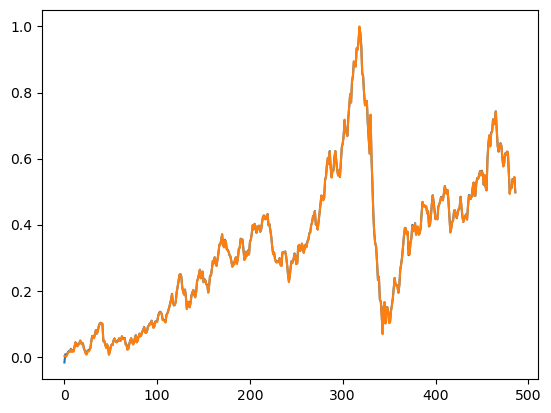

In [170]:
plt.plot(train_X_pred)
plt.plot(train_data[:,0])

In [171]:
regr_net_without_Z = Regressor(input_size = data.shape[1]-1, hidden_size = data.shape[1] * 4).cuda()
regr_net_without_Z_optim = optim.Adam(regr_net_without_Z.parameters(), lr = 1e-5, weight_decay = 1e-5)
loss_array, train_X_pred_without_Z = train_reg_withoutZ(train_data, regr_net_without_Z, regr_net_without_Z_optim, iter_num = 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_263429/3080543610.py:14: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
100%|██████████| 5000/5000 [00:17<00:00, 277.86it/s]


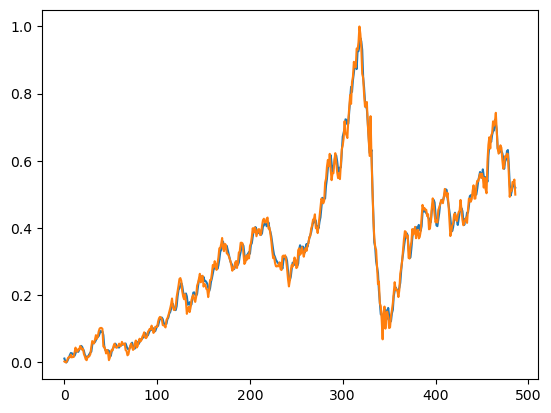

In [172]:
plt.plot(train_X_pred_without_Z)
plt.plot(train_data[:,0])

In [173]:
def test(data, Z, regr_net):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    Z = torch.autograd.Variable(torch.FloatTensor(Z)).cuda()
    
    X_pred = regr_net(torch.cat((Y, Z), axis = 1))
    mseloss = torch.nn.MSELoss(reduction = 'sum')
    loss = mseloss(X_pred, X)

    # Mutual Information
    # t = mine_net( torch.cat((X, Y, Z), axis = 1) )
    # marginal_t = mine_net( torch.cat((marginal_X, Y, Z), axis = 1) )
    # et = torch.exp(marginal_t)
    # mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return loss.detach(), X_pred.detach().cpu().numpy()

In [174]:
def test_without_Z(data, regr_net):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()

    # Z, h_state = zrnn_net( torch.cat((X, Y), axis = 1), h_state)
    # Z = Z.detach().cpu().numpy()
    # Z = torch.autograd.Variable(torch.FloatTensor(Z)).cuda()
    # norm_Z = (Z - Z.min())/(Z.max() - Z.min())

    # X_pred = regr_net(torch.cat((Y, norm_Z), axis = 1))
    X_pred = regr_net(Y)
    mseloss = torch.nn.MSELoss(reduction = 'sum')
    loss = mseloss(X_pred, X)


    # Mutual Information
    # t = mine_net( torch.cat((X, Y, Z), axis = 1) )
    # marginal_t = mine_net( torch.cat((marginal_X, Y, Z), axis = 1) )
    # et = torch.exp(marginal_t)
    # mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return loss.detach(), X_pred.detach().cpu().numpy()

In [175]:
test_loss, X_pred = test(test_data, test_Z, regr_net)

In [176]:
MSEloss = np.mean(np.square(test_data[10:,0] - X_pred[10:].T))
MSEloss

2.1525194379061327e-05

In [177]:
test_loss, X_pred_without_Z = test_without_Z(test_data, regr_net_without_Z)

In [178]:
MSEloss = np.mean(np.square(test_data[:,0] - X_pred_without_Z[:].T))
MSEloss

0.001292400737984219

In [179]:
MSEloss = np.mean(np.square(test_data[1:,0] - test_data[:-1,0]))
MSEloss

0.0004064257658012435

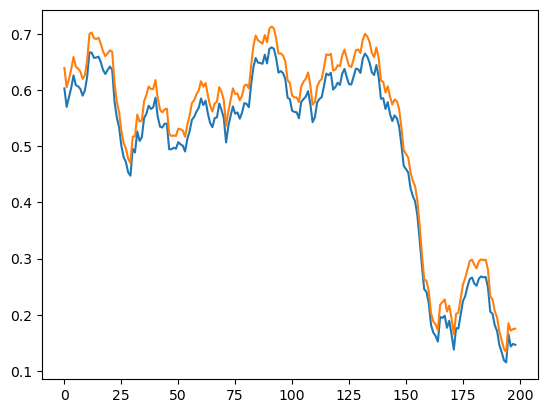

In [78]:
plt.plot(X_pred[:])
plt.plot(test_data[:,0])

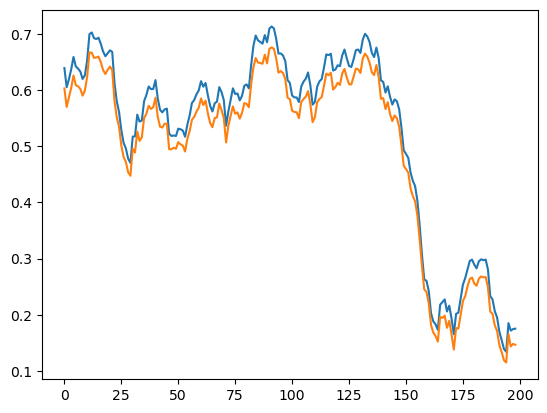

In [79]:
# plt.plot(X_pred_without_Z[10:])
plt.plot(test_data[:,0])
plt.plot(X_pred[:])

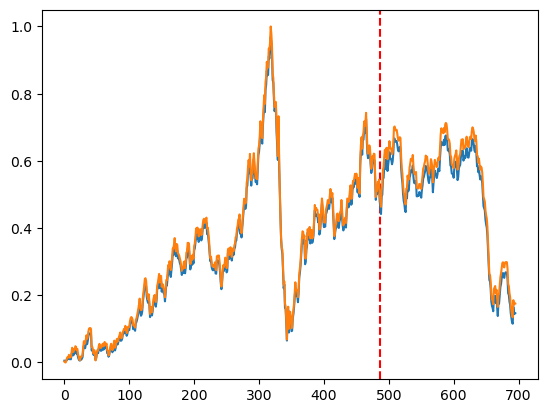

In [80]:
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(np.concatenate((train_X_pred, X_pred)))
plt.plot(data[:,0])

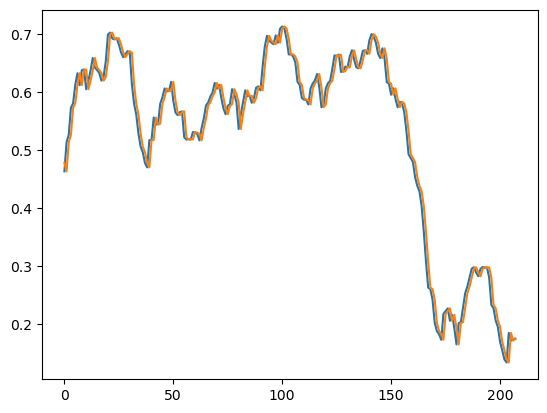

In [81]:
plt.plot(data[1:,0][train_size:])
plt.plot(data[:-1,0][train_size:])

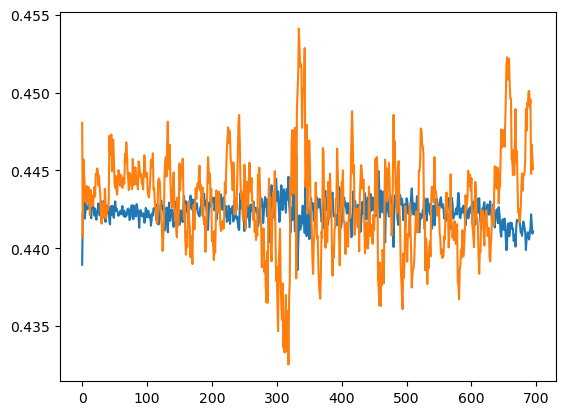

In [83]:
dum = np.zeros(Z.shape[0])
# for i in range(Z.shape[1]):
for i in range(int(Z.shape[1]/20)*10, int(Z.shape[1]/20)*11):
    z = Z[:, i]
    # z = (z - z.min())/(z.max() - z.min())
    plt.plot(z)
    # dum += z

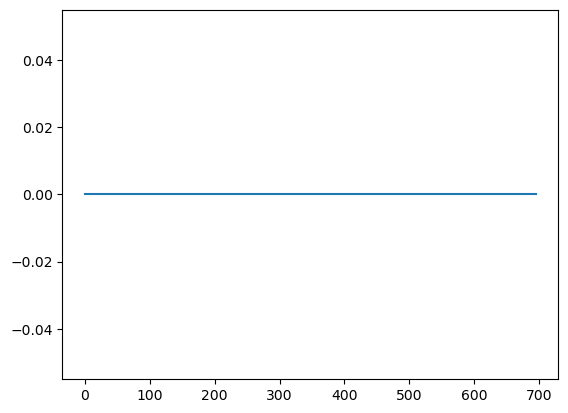

In [84]:
plt.plot(dum)

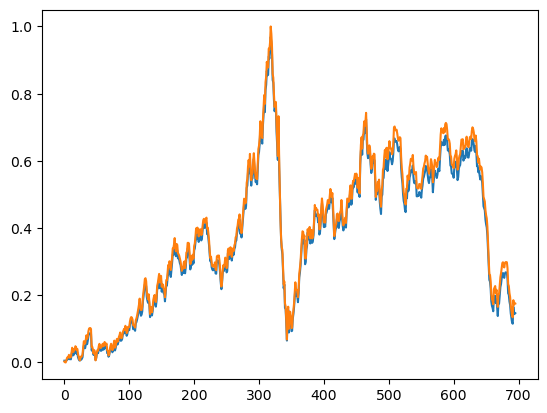

In [85]:
plt.plot(np.concatenate((train_X_pred, X_pred)))
plt.plot(data[:,0])

In [101]:
def mutual_information_explicit(joint_X, marginal_X, Y, mine_net):
    t = mine_net( torch.cat((joint_X, Y), axis = 1) )
    marginal_t = mine_net( torch.cat((marginal_X, Y), axis = 1) )

    # Z, h_state = zrnn_net( torch.cat((joint_X[:-1, :], Y[:-1, :]), 1), h_state)
    # t = mine_net( torch.cat((joint_X[1:, :], Y[1:, :], Z), axis = 1) )
    # marginal_t = mine_net( torch.cat((marginal_X[1:, :], Y[1:, :], Z), axis = 1) )

    et = torch.exp(marginal_t)
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine_explicit(X, Y, mine_net, mine_net_optim, ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    marginal_X = X[index]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    marginal_X = torch.autograd.Variable(torch.FloatTensor(marginal_X)).cuda()

    mi_lb, t, et = mutual_information_explicit(X, marginal_X, Y, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [102]:
def train_explicit(data, mine_net, mine_net_optim, batch_size=100, iter_num=int(1e+3) , log_freq=int(1e+2)):
# def train(data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, batch_size=100, iter_num=3000, log_freq=int(1e+2)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in tqdm(range(iter_num)):
        X = np.expand_dims(data[:, 0], 1)
        Y = data[:, 1:]
        # Y = np.expand_dims(data[:, 0], 1)
        if Y.ndim == 1:
            Y = np.expand_dims(Y, 1)

        mi_lb, ma_et = learn_mine_explicit(X, Y, mine_net, mine_net_optim, ma_et)
        # if (i+1)%(10)==0:
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [112]:
mine_net_explicit = Mine(input_size = data.shape[1]).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)

In [113]:
result_explicit = train_explicit(data, mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(1e+5), log_freq=int(1e+4))

 10%|█         | 10023/100000 [00:47<08:47, 170.68it/s]

2.5626137


 20%|██        | 20021/100000 [01:33<06:35, 202.42it/s]

2.5499206


 30%|███       | 30041/100000 [02:20<05:22, 216.80it/s]

2.2877145


 40%|████      | 40030/100000 [03:06<03:47, 263.19it/s]

2.8675206


 50%|█████     | 50047/100000 [03:53<03:36, 231.17it/s]

2.5916684


 60%|██████    | 60054/100000 [04:34<01:24, 474.31it/s]

3.1621706


 70%|███████   | 70050/100000 [05:04<01:15, 397.78it/s]

3.0828292


 80%|████████  | 80042/100000 [05:47<01:22, 242.18it/s]

2.761826


 90%|█████████ | 90044/100000 [06:33<00:37, 262.47it/s]

2.860055


100%|██████████| 100000/100000 [07:20<00:00, 226.97it/s]


3.1887183


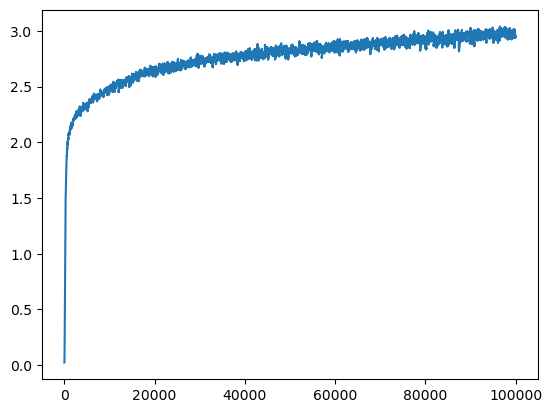

In [114]:
plt.plot(range(len(ma(result_explicit))), ma(result_explicit))


In [115]:
# mine_net_explicit = Mine(input_size = data.shape[1]) #.cuda()
mine_net_explicit = Mine(input_size = 2).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)

In [116]:
result_explicit = train_explicit(np.concatenate((np.expand_dims(data[:, 0], 1), (np.expand_dims(data[:, 0], 1))), 1), mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(1e+5), log_freq=int(1e+4))

 10%|█         | 10031/100000 [00:47<08:18, 180.39it/s]

4.4990234


 20%|██        | 20038/100000 [01:33<05:12, 255.82it/s]

5.2105465


 30%|███       | 30037/100000 [02:19<05:21, 217.67it/s]

4.87204


 40%|████      | 40071/100000 [02:59<02:38, 378.88it/s]

4.106169


 50%|█████     | 50034/100000 [03:36<03:05, 269.07it/s]

4.653803


 60%|██████    | 60045/100000 [04:22<02:40, 248.82it/s]

5.4876804


 70%|███████   | 70083/100000 [05:06<01:23, 358.55it/s]

5.079472


 80%|████████  | 80041/100000 [05:51<01:32, 214.72it/s]

5.6648774


 90%|█████████ | 90041/100000 [06:36<00:46, 216.28it/s]

4.4793553


100%|██████████| 100000/100000 [07:21<00:00, 226.54it/s]


4.645871


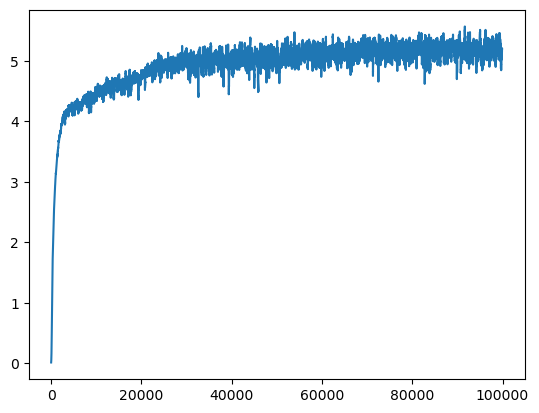

In [118]:
plt.plot(range(len(ma(result_explicit))), ma(result_explicit))